# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objectives

At the end of the experiment you will be able to :

- predict bitcoin price using Neural Network


In [ ]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="850" height="480" controls>
  <source src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Walkthrough/Bitcoin_Price_Prediction_Walkthrough.mp4" type="video/mp4">
</video>
""")

## Dataset

### Description

In this Dataset, Bitcoin USD values from 1st Jan, 2017 to 15th Nov, 2019 downloaded from yahoo finance having one day resolution. It can be used to check simple time-series forecasting models.

This dataset contains 1049 rows and 7 features including Date,	Open,	High,	Low,	Close,	Adj Close and	Volume




Stock price forecasting is one of the most challenging tasks in financial decision-making because stock prices are inherently noisy and non-stationary and have been observed to have a random-walk characteristic. Accurate stock price predictions can yield significant profits and therefore econometric and statistical approaches including linear/non-linear methods.

## Domain Information

Time-series forecasting means predicting future values in time. Developing a forecasting model depends on the forecasting horizon. Very short-term forecasting would typically involve predicting the value at the next minute or hour, short-term forecasting has a horizon of days or weeks, long-term forecasting is done for months or a year or two, and we also have very-long term forecasting that could easily have a horizon of up to a few decades.

Here, we will build a simple Deep Learning based very-short-term Time-series forecaster, that will predict the stock prices of Bitcoin.

In [ ]:
! wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/bitcoin.csv


### Importing required packages

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa import stattools

# Keras imports
from keras.layers import Input, Dense, Dropout
from keras.models import Model

### Load the data

In [ ]:
df = pd.read_csv('/content/bitcoin.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.66,1003.08,958.70,998.33,998.33,147775008
1,2017-01-02,998.62,1031.39,996.70,1021.75,1021.75,222184992
2,2017-01-03,1021.60,1044.08,1021.60,1043.84,1043.84,185168000
3,2017-01-04,1044.40,1159.42,1044.40,1154.73,1154.73,344945984
4,2017-01-05,1156.73,1191.10,910.42,1013.38,1013.38,510199008


### Plotting the Time-series

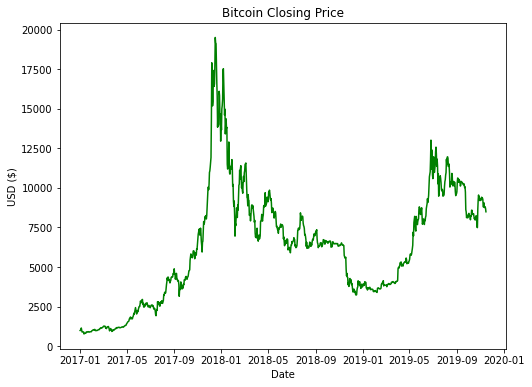

In [ ]:
df_close = pd.DataFrame(df['Close'])
df_close.index = pd.to_datetime(df['Date'])

plt.figure(figsize=(8, 6))
plt.plot(df_close, color='g')
plt.title('Bitcoin Closing Price')
plt.xlabel('Date')
plt.ylabel('USD ($)')
plt.show()

### Auto Correlation Function
In autocorrelation, we take the time-series value at current instant as one variable and one of the values from a time-instant in the past as the other variable, and find the correlation between them. `stattools.acf` (acf for autocorrelation function) is used to plot the autocorrelation with 50 past time-instants (lags).

For example the ACF for a time series  is given by:

$ Corr = (y_t, y_{t-k})$

This value of k is the time gap being considered and is called the lag. A lag 1 autocorrelation (i.e., k = 1 in the above) is the correlation between values that are one time period apart. More generally, a lag k autocorrelation is the correlation between values that are k time periods apart.



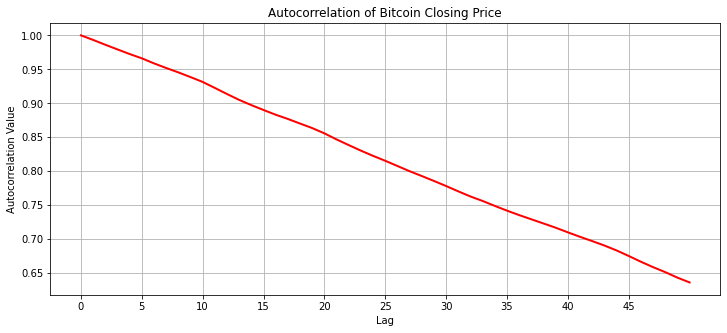

In [ ]:
acf_lags = stattools.acf(df_close, nlags=50)

plt.figure(figsize=(12, 5))
plt.plot(acf_lags, color='r', linewidth=2)
plt.title('Autocorrelation of Bitcoin Closing Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Value')
plt.xticks(range(0,50,5))
plt.grid()
plt.show()

From the above plot we can observe that, after 15 time instants (lags) the correlation value is less than 0.9, correlation is a way to measure the strength of association between any two variables. As the correlation value approaches 1, it indicates high positive association. Correlation near 0 indicates almost no association at all. So, ignore time instants (lags) having a correlation value less than 0.9

### Creation of dataset for training

Below Function to create the data with 15 lags (past 15 days of data) 

In [ ]:
def create_lags_data(df, attributes, list_of_prev_t_instants) :

    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """

    start = len(list_of_prev_t_instants)
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)
    
    # Make a copy of original dataframe
    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attributes:
        # Create the new empty dataframe
        data = pd.DataFrame()
        for prev_t in list_of_prev_t_instants :
            # Slicing the Dataframe with 15 lags
            new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
            new_col.reset_index(drop=True, inplace=True)
            # To rename the columns as Close(t-1), Close(t-2) and so on .... 
            new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
            data = pd.concat([data, new_col], sort=False, axis=1)

        df_copy = pd.concat([df_copy, data], sort=False, axis=1)

    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [ ]:
# Defining the Attributes and t_instances to create the lagged data
list_of_attributes = ['Close']
list_of_prev_t_instants = np.arange(1,16)
list_of_prev_t_instants

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [ ]:
# Call the function to create data with 14 lags
df_new = create_lags_data(df_close, list_of_attributes, list_of_prev_t_instants)
df_new

,Close,Close_(t-1),Close_(t-2),Close_(t-3),Close_(t-4),Close_(t-5),Close_(t-6),Close_(t-7),Close_(t-8),Close_(t-9),Close_(t-10),Close_(t-11),Close_(t-12),Close_(t-13),Close_(t-14),Close_(t-15)
datetime,,,,,,,,,,,,,,,,
2017-01-16,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38,1154.73,1043.84,1021.75,998.33
2017-01-17,907.94,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38,1154.73,1043.84,1021.75
2017-01-18,886.62,907.94,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38,1154.73,1043.84
2017-01-19,899.07,886.62,907.94,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38,1154.73
2017-01-20,895.03,899.07,886.62,907.94,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-11,8757.79,9055.53,8813.58,8804.88,9267.56,9360.88,9342.53,9412.61,9235.35,9324.72,9261.10,9199.58,9205.73,9427.69,9256.15,9551.71
2019-11-12,8815.66,8757.79,9055.53,8813.58,8804.88,9267.56,9360.88,9342.53,9412.61,9235.35,9324.72,9261.10,9199.58,9205.73,9427.69,9256.15
2019-11-13,8808.26,8815.66,8757.79,9055.53,8813.58,8804.88,9267.56,9360.88,9342.53,9412.61,9235.35,9324.72,9261.10,9199.58,9205.73,9427.69


### Build and compile the model

Training a simple Network that has an input layer with 15 nodes (accounting for each of the 15 past regressor inputs).

In [ ]:
input_layer = Input(shape=(15), dtype='float32')
dense1 = Dense(30, activation='linear')(input_layer)
dense2 = Dense(30, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 30)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


### Split the data into train and test

Define the features and labels from the data and split data into train and test  in 90-10 split ratio

In [ ]:
df_copy = df_new.reset_index(drop=True)

from sklearn.model_selection import train_test_split
features = df_copy.iloc[:, 1:]
labels = df_copy.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1)
X_train.shape, y_train.shape

print('The Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('The Shape of test inputs, test target:', X_test.shape, y_test.shape)

The Shape of training inputs, training target: (930, 15) (930,)
The Shape of test inputs, test target: (104, 15) (104,)


### Scaling the data

Normalize the data before feeding it to the neural network.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler()
Feature_scaler = MinMaxScaler()

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

### Training and Validation

In [ ]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=10, shuffle=True)

Epoch 1/10
186/186 [==============================] - 1s 1ms/step - loss: 0.0152
Epoch 2/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 3/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 4/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 5/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 6/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 7/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 8/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 9/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 10/10
186/186 [==============================] - 0s 1ms/step - loss: 0.0018


### Making predictions on the test set

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
# Rescaling the predicted data and actual data to plot
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)

### Plotting the predictions

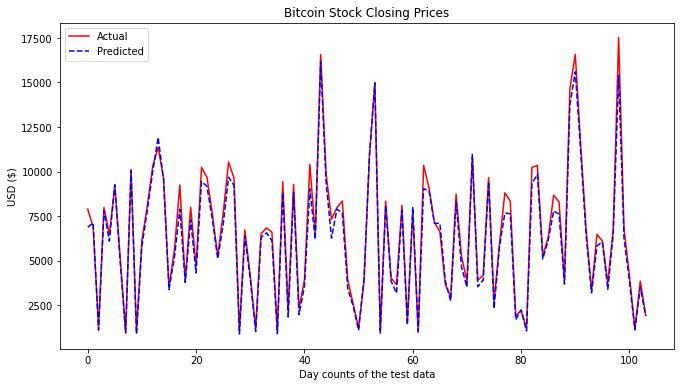

In [ ]:
plt.figure(figsize=(11, 6))
plt.plot(y_test_rescaled, linestyle='solid', color='r')
plt.plot(y_pred_rescaled, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'])
plt.title('Bitcoin Stock Closing Prices')
plt.ylabel('USD ($)')
plt.xlabel('Day counts of the test data')

plt.show()